# Bayesian Performance Evaluation and Comparison

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import pymc3 as pm
from pymc3.plots import forestplot, autocorrplot, compareplot, plot_posterior,traceplot
from scipy import stats
import empyrical as ep
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
with pd.HDFStore('../data/assets.h5') as store:
    benchmark= store['sp500/prices'].close.to_frame('benchmark')
    stock = store['quandl/wiki/prices'].adj_close.unstack()['AMZN'].to_frame('stock')

In [3]:
data = stock.join(benchmark).pct_change().dropna().loc['2010':]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2113 entries, 2010-01-04 to 2018-03-27
Data columns (total 2 columns):
stock        2113 non-null float64
benchmark    2113 non-null float64
dtypes: float64(2)
memory usage: 49.5 KB


## Modeling the Sharpe Ratio

### Define Probability Model

In [5]:
mean_prior = data.stock.mean()
std_prior = data.stock.std()
std_low = std_prior / 1000
std_high = std_prior * 1000

with pm.Model() as sharpe_model:
    mean = pm.Normal('mean', mu=mean_prior, sd=std_prior)
    std = pm.Uniform('std', lower=std_low, upper=std_high)

    nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
    returns = pm.StudentT('returns', nu=nu, mu=mean, sd=std, observed=data.stock)

    sharpe = returns.distribution.mean / returns.distribution.variance ** .5 * np.sqrt(252)
    pm.Deterministic('sharpe', sharpe)

In [6]:
sharpe_model.model

### Visualize Model

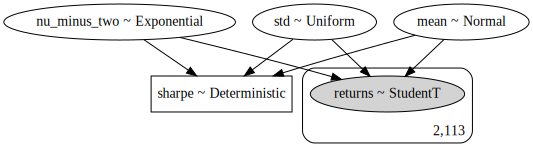

In [7]:
pm.model_to_graphviz(model=sharpe_model)

In [8]:
graph = pm.model_to_graphviz(model=sharpe_model)
graph.save('figures/sharpe.dot')

'figures/sharpe.dot'

### Approximate Inference: Hamiltonian Monte Carlo with the No U-Turn Sampler

In [10]:
tune = 2000
draws = 200
with sharpe_model:
    trace = pm.sample(tune=tune, draws=draws, chains=4, cores=4)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, std, mean]
Sampling 4 chains: 100%|██████████| 8800/8800 [00:09<00:00, 950.23draws/s] 


### Inspect Trace

In [11]:
trace_df = pm.trace_to_dataframe(trace).assign(chain=lambda x: x.index // draws)
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
mean            800 non-null float64
std             800 non-null float64
nu_minus_two    800 non-null float64
sharpe          800 non-null float64
chain           800 non-null int64
dtypes: float64(4), int64(1)
memory usage: 31.3 KB


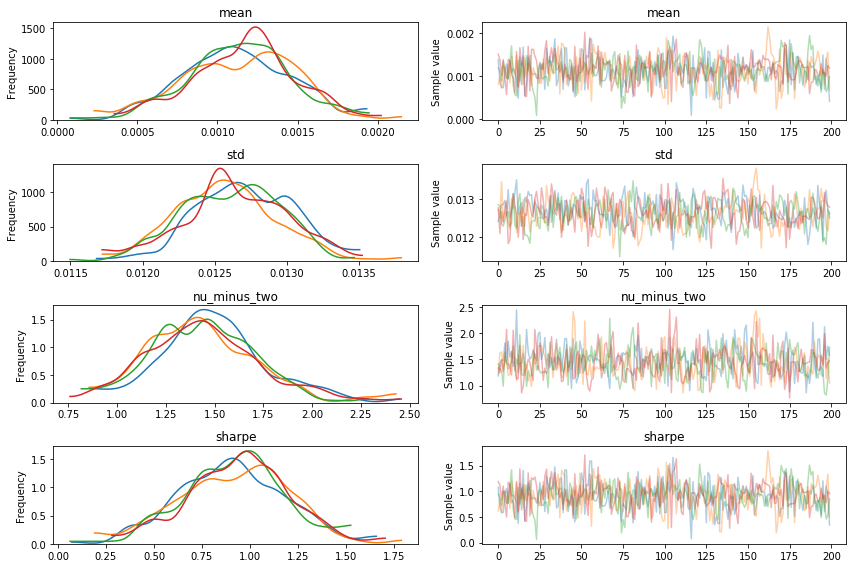

In [12]:
traceplot(trace=trace);

### Continue Sampling

In [13]:
draws = 5000
with sharpe_model:
    trace = pm.sample(draws=draws, trace=trace, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, std, mean]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:16<00:00, 1340.67draws/s]
The acceptance probability does not match the target. It is 0.894827168017169, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834648931751635, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907290382545082, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891463800163346, but should be close to 0.8. Try to increase the number of tuning steps.


In [14]:
pm.trace_to_dataframe(trace).shape

(20800, 4)

In [15]:
df = pm.trace_to_dataframe(trace).iloc[400:].reset_index(drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(run=1),
                      df.assign(run=2)])
trace_df.info()        

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21200 entries, 0 to 20399
Data columns (total 6 columns):
mean            21200 non-null float64
std             21200 non-null float64
nu_minus_two    21200 non-null float64
sharpe          21200 non-null float64
chain           21200 non-null int64
run             21200 non-null int64
dtypes: float64(4), int64(2)
memory usage: 1.1 MB


In [16]:
trace_df_long = pd.melt(trace_df, id_vars=['run', 'chain'])
trace_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84800 entries, 0 to 84799
Data columns (total 4 columns):
run         84800 non-null int64
chain       84800 non-null int64
variable    84800 non-null object
value       84800 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.6+ MB


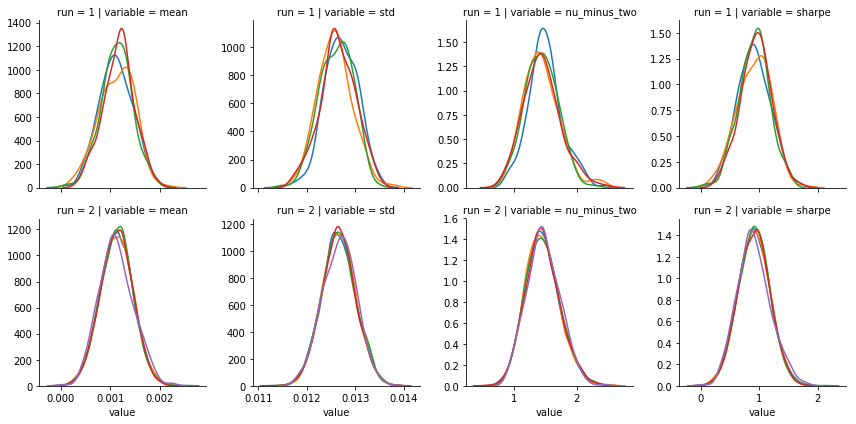

In [18]:
g = sns.FacetGrid(trace_df_long, col='variable', row='run', hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False)
g.savefig('figures/sharpe_runs', dpi=300)

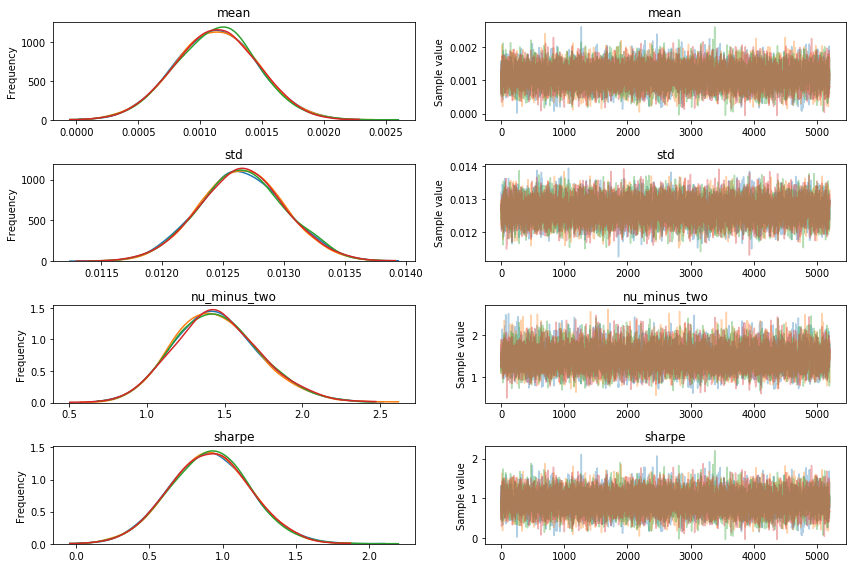

In [17]:
traceplot(trace=trace);

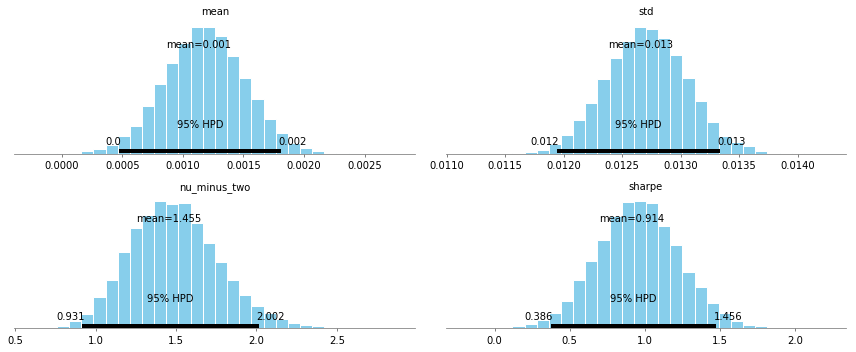

In [20]:
plot_posterior(trace=trace);

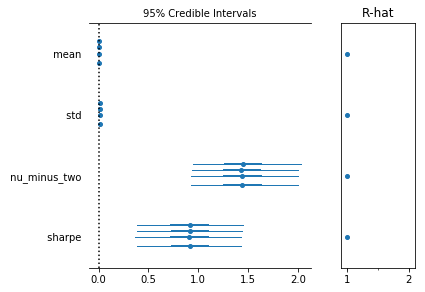

In [19]:
forestplot(trace=trace);

## Comparing Group Means: Bayesian Estimation Supersedes the T-Test (BEST)

This model runs a Bayesian hypothesis test to compare two return distributions. The returns could be for two different assets, or the in-sampls and out-of-sample returns for a target strategy. Returns are assumed to be T-distributed.

In addition, it computes the annualize volatility and Sharpe ratios for both return series.

The model is based on [Bayesian estimation supersedes the t-test](http://www.indiana.edu/~kruschke/BEST/BEST.pdf), John Kruschke, Journal of Experimental Psychology, 2012.

It is included in pyfolio's Bayesian tearsheet.

### The Data

In [33]:
data.describe()

,stock,benchmark
count,2113.000000,2113.000000
mean,0.001328,0.000446
std,0.019416,0.009294
min,-0.126568,-0.066634
25%,-0.008168,-0.003234
50%,0.000574,0.000414
75%,0.011451,0.004897
max,0.157457,0.047407


### Sharpe Ratio Comparison as a Probabilistic Model

In [56]:
group = {1: data.stock, 2: data.benchmark}
combined = pd.concat([g for i, g in group.items()])

# priors
mean_prior = combined.mean()
std_prior = combined.std()
std_low = std_prior / 1000
std_high = std_prior * 1000
T = 251 ** .5
mean, std, returns = {}, {}, {}
with pm.Model() as best:
    nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
    for i in [1, 2]:
        mean[i] = pm.Normal(f'mean_g{i}', mu=mean_prior, sd=std_prior, testval=group[i].mean())
        std[i] = pm.Uniform(f'std_g{i}', lower=std_low, upper=std_high, testval=group[i].std())
        returns[i] = pm.StudentT(f'returns_g{i}', nu=nu, mu=mean[i], sd=std[i], observed=group[i])
        pm.Deterministic(f'vol_g{i}', returns[i].distribution.sd * T)
        pm.Deterministic(f'sharpe_g{i}', returns[i].distribution.mean / returns[i].distribution.sd * T)
        
    mean_diff = pm.Deterministic('mean diff', mean[1] - mean[2])
    pm.Deterministic('std diff', std[1] - std[2])
    pm.Deterministic('effect size', mean_diff / (std[i] ** 2 + std[2] ** 2) ** .5 / 2)

#### Inspecting the Model

In [57]:
best.model

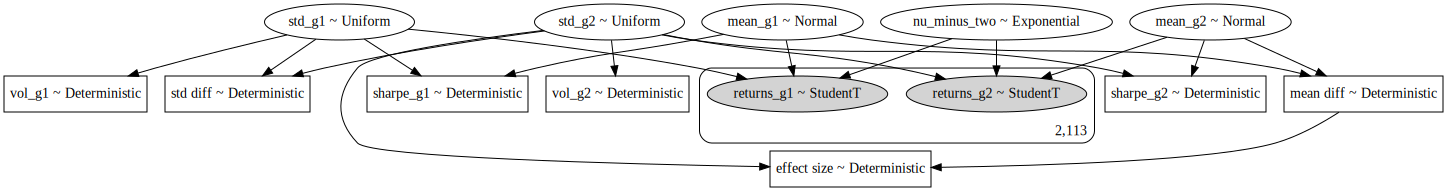

In [58]:
pm.model_to_graphviz(model=best)

### HMC NUTS Sampling

In [59]:
with best:    
    trace = pm.sample(draws=10000, tune=2500, progressbar=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std_g2, mean_g2, std_g1, mean_g1, nu_minus_two]
Sampling 4 chains: 100%|██████████| 50000/50000 [00:33<00:00, 1496.30draws/s]


In [60]:
pm.trace_to_dataframe(trace).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
mean_g1         40000 non-null float64
mean_g2         40000 non-null float64
nu_minus_two    40000 non-null float64
std_g1          40000 non-null float64
vol_g1          40000 non-null float64
sharpe_g1       40000 non-null float64
std_g2          40000 non-null float64
vol_g2          40000 non-null float64
sharpe_g2       40000 non-null float64
mean diff       40000 non-null float64
std diff        40000 non-null float64
effect size     40000 non-null float64
dtypes: float64(12)
memory usage: 3.7 MB


### Evaluating the Trace

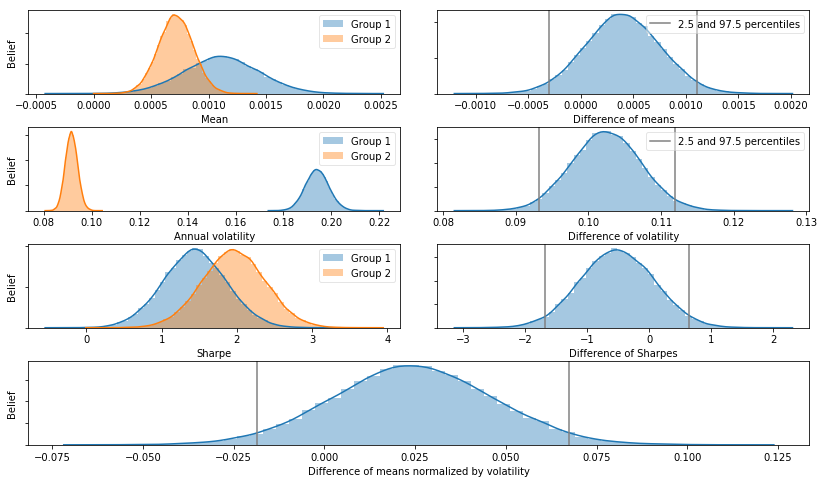

In [79]:
burn = 0
trace = trace[burn:]

fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, wspace=0.1, hspace=0.4)
axs = [plt.subplot(gs[i, j]) for i in [0, 1, 2] for j in [0, 1]]
axs.append(plt.subplot(gs[3, :]))

def distplot_w_perc(trace, ax):
    sns.distplot(trace, ax=ax)
    ax.axvline(stats.scoreatpercentile(trace, 2.5), color='0.5', label='2.5 and 97.5 percentiles')
    ax.axvline(stats.scoreatpercentile(trace, 97.5), color='0.5')

for i in [1, 2]:
    label = f'Group {i}'
    sns.distplot(trace[f'mean_g{i}'], ax=axs[0], label=label)
    sns.distplot(trace[f'vol_g{i}'], ax=axs[2], label=label)
    sns.distplot(trace[f'sharpe_g{i}'], ax=axs[4], label=label)

distplot_w_perc(trace['mean diff'], axs[1])
distplot_w_perc(trace['vol_g1'] - trace['vol_g2'], axs[3])
distplot_w_perc(trace['sharpe_g1'] - trace['sharpe_g2'], axs[5]) 

sns.distplot(trace['effect size'], ax=axs[6])
for p in [2.5, 97.5]:
    axs[6].axvline(stats.scoreatpercentile(trace['effect size'], p), color='0.5')

for i in range(5):
    axs[i].legend(loc=0, frameon=True, framealpha=0.5)

axs[0].set(xlabel='Mean', ylabel='Belief', yticklabels=[])
axs[1].set(xlabel='Difference of means', yticklabels=[])
axs[2].set(xlabel='Annual volatility', ylabel='Belief', yticklabels=[])
axs[3].set(xlabel='Difference of volatility', yticklabels=[])
axs[4].set(xlabel='Sharpe', ylabel='Belief', yticklabels=[])
axs[5].set(xlabel='Difference of Sharpes', yticklabels=[])
axs[6].set(xlabel='Difference of means normalized by volatility', ylabel='Belief', yticklabels=[])
fig.savefig('figures/sharpe_comp', dpi=300)

In [40]:
def plot_traces(traces, burnin=2000):
    ''' 
    Plot traces with overlaid means and values
    '''
    summary = pm.summary(traces[burnin:])['mean'].to_dict()
    ax = pm.traceplot(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

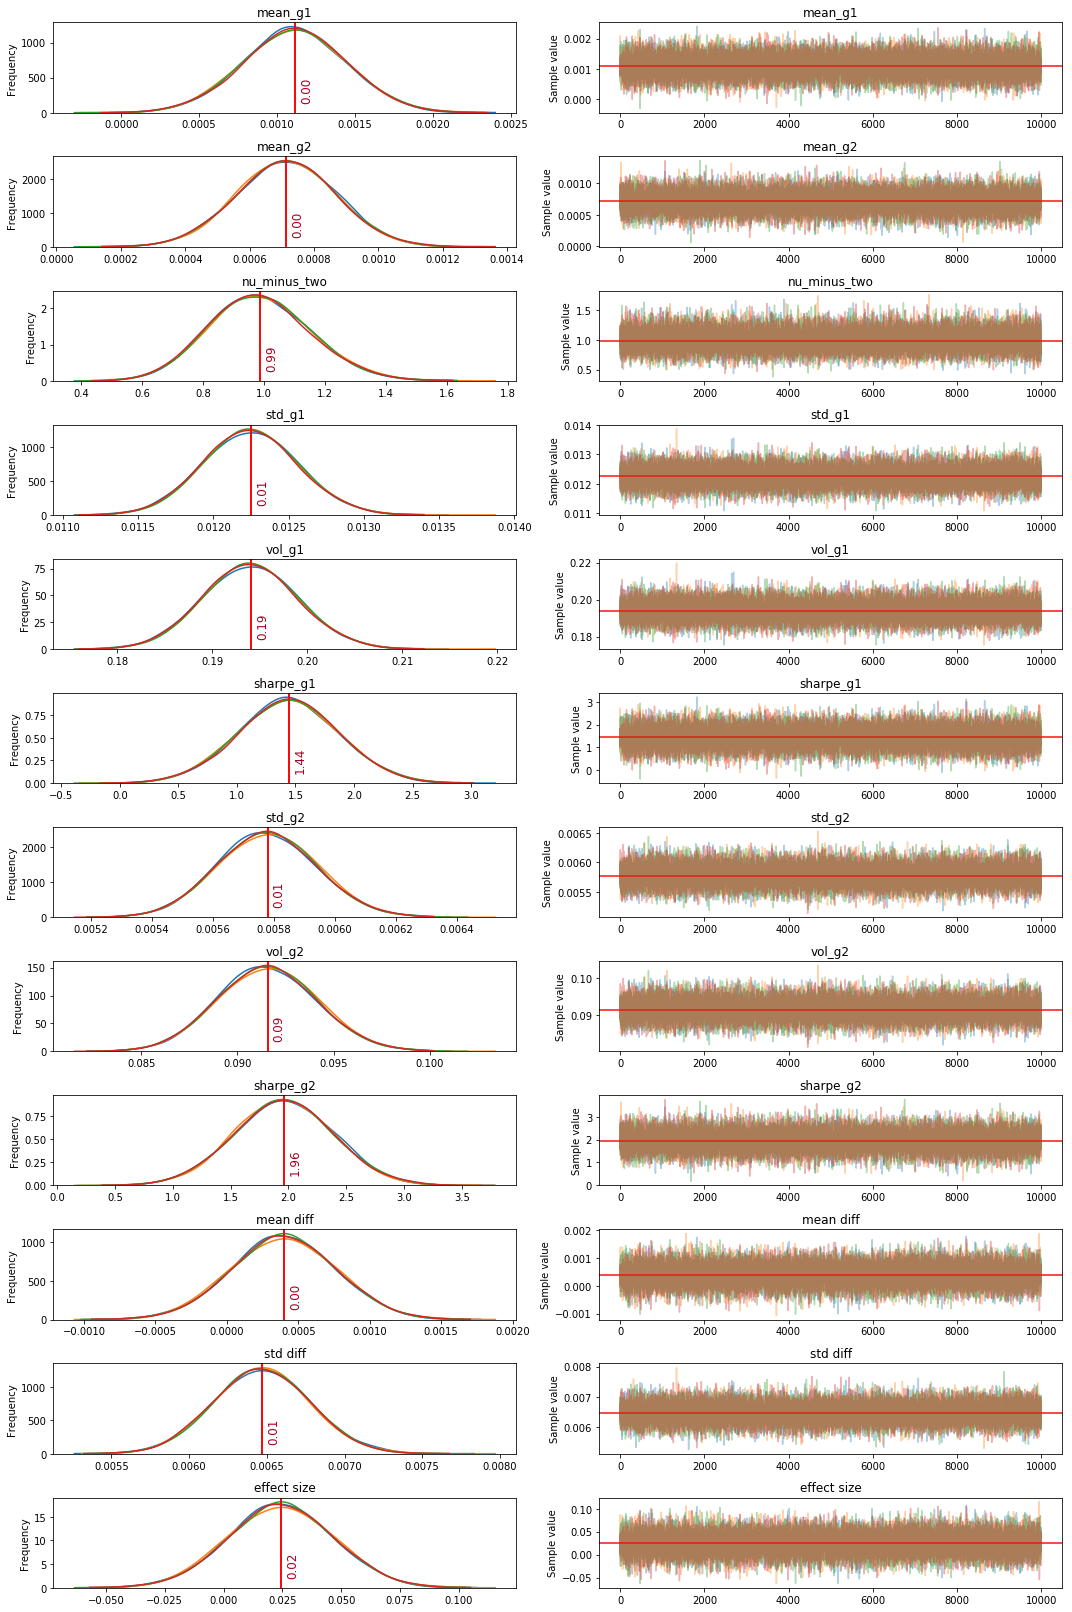

In [78]:
plot_traces(trace, burnin=0)